In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
import bout as bt
from core import SITE_NAMES, FREQ_GROUPS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE

from cli import get_file_paths
import plot
import pipeline

In [4]:
POINT_CMAP = {0:'w',1:'r',2:'b',3:'g',4:'orange',5:'c',6:'pink',7:'k'}
POINT_CMAP

{0: 'w', 1: 'r', 2: 'b', 3: 'g', 4: 'orange', 5: 'c', 6: 'pink', 7: 'k'}

In [5]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]
reset_24

array([  6,  12,  18,  24,  30,  36,  48,  60,  72,  90,  96, 120, 144,
       180, 240, 288, 360, 480, 720])

In [6]:
cycle_lengths = [6, 18, 30, 60, 144, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
data_params['index_time_block_in_secs'] = '5'
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

In [7]:
site_key = 'Carp'
type_keys = ['LF', 'HF']
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]

# for type_key in type_keys:
type_key = 'LF'
print(site_key, type_key)
data_params["type_tag"] = type_key
file_paths = get_file_paths(data_params)
file_paths

Carp LF


{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'SITE_classes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp',
 'SITE_classes_file': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp/2022_Carp_call_classes.csv',
 'bd2_TYPE_SITE_YEAR': 'bd2__LFCarp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_LFCarp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_LFCarp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_LFCarp_summary',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Carp',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_LFCarp',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_LFCarp',
 

In [8]:
def plot_indiv_dc_control_comp_over_cycle(single_col_dc_metr1, single_col_c_metr, data_params):
    dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
    total = int(dc_tag_split[-1])
    single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
    dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                        columns=single_col_dc_metr1.index.date, 
                        values=single_col_dc_metr1.columns[0])
    dctag1 = re.search(r"\d+of\d+", single_col_dc_metr1.columns[0])[0]
    metrictag1 = (single_col_dc_metr1.columns[0]).split()[0]
    single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
    paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    plt.title(f'{dctag1} and continuous scheme')
    plt.plot([0, np.amax(c_metr)], [0, np.amax(c_metr)], linestyle='dashed', color='k')
    colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
    labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
    sc = plt.scatter(c_metr, dc_metr1, c=colors, cmap='YlOrRd', edgecolors='k', s=50, alpha=0.8)
    cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
    cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
    plt.xlabel(f'Continuous Measured {metrictag1}')
    plt.xscale('log')
    plt.yscale('log')
    if (data_params['metric_tag'] == 'bout_time'):
        plt.xlim(1e-2, 1e2)
        plt.ylim(1e-2, 1e2)
    else:
        plt.xlim(1e-1, np.amax(c_metr))
        plt.ylim(1e-1, np.amax(c_metr))
    plt.ylabel(f'DC Measured {metrictag1}')
    plt.grid(which='both')

In [9]:
def are_there_expected_number_of_cycles(location_df, num_of_detections, cycle_length):
    first_date = pd.to_datetime(location_df['call_start_time']).iloc[0].date()
    last_date = (pd.to_datetime(location_df['call_start_time'])).iloc[-1].date()
    first_dt = dt.datetime.combine(first_date, pd.to_datetime(data_params['recording_start'], format="%H:%M").time())
    last_dt = dt.datetime.combine(last_date, pd.to_datetime(data_params['recording_end'], format="%H:%M").time())

    all_cycles = pd.date_range(first_dt, last_dt, freq=f'{cycle_length}T')
    between_time_cycles = all_cycles[(all_cycles.indexer_between_time(data_params['recording_start'], data_params['recording_end']))]
    
    assert num_of_detections.shape[0] <= between_time_cycles.shape[0]

In [10]:
def all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs):
    resampled_cycle_length_df = dc_applied_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    last_call_of_each_group = resampled_cycle_length_df.last()
    assert last_call_of_each_group['end_time_wrt_ref'].all() < time_on_in_secs

In [11]:
def simulate_dutycycle_on_detections(location_df, cycle_length, time_on_in_secs, data_params):
    """
    Simulates a provided duty-cycling scheme on the provided location summary of concatenated bd2 outputs.
    """ 

    location_df = assign_cycle_groups_to_each_call(location_df, cycle_length, data_params)
    dc_applied_df = gather_calls_existing_in_on_windows(location_df, time_on_in_secs)
    all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs)

    return dc_applied_df

def gather_calls_existing_in_on_windows(location_df, time_on_in_secs):

    location_df.insert(0, 'end_time_wrt_ref', (location_df['call_end_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    location_df.insert(0, 'start_time_wrt_ref', (location_df['call_start_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    dc_applied_df = location_df.loc[(location_df['end_time_wrt_ref'] <= time_on_in_secs)&(location_df['start_time_wrt_ref'] >= 0)].copy()

    return dc_applied_df

def assign_cycle_groups_to_each_call(location_df, cycle_length, data_params):
    location_df['ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['cycle_ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['call_end_time'] = pd.DatetimeIndex(location_df['call_end_time'])
    location_df['call_start_time'] = pd.DatetimeIndex(location_df['call_start_time'])

    resampled_cycle_length_df = location_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    first_call_of_each_group = resampled_cycle_length_df.first().between_time(data_params['recording_start'], data_params['recording_end'])
    are_there_expected_number_of_cycles(location_df, first_call_of_each_group, cycle_length)
    location_df['cycle_ref_time'] = pd.DatetimeIndex(resampled_cycle_length_df['cycle_ref_time'].transform(lambda x: x.name))

    return location_df

In [12]:
def get_number_of_detections_per_cycle(location_df, cycle_length):

    df_resampled_every_30 = location_df.resample(f"{cycle_length}T", on='cycle_ref_time')
    num_of_detections = df_resampled_every_30['cycle_ref_time'].count()

    return num_of_detections

def get_metric_per_time_on(metric, time_on):

    return metric / (time_on)

def filter_and_prepare_metric(metric, dc_tag, data_params):

    col_name = f"{data_params['metric_tag']} ({dc_tag})"
    incomplete_activity_arr = pd.DataFrame(metric.values, index=metric.index, columns=[col_name])
    activity_arr = incomplete_activity_arr.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    return pd.DataFrame(list(zip(activity_arr.index, activity_arr[col_name].values)), columns=["datetime_UTC", col_name])

In [13]:
def does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df):
    assert dc_applied_df.shape[0] < location_df.shape[0]

In [14]:
def generate_activity_call_rate_for_dc_schemes(data_params, file_paths):
    activity_arr = pd.DataFrame()
    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)

    dc_schemes = data_params['dc_tags'][1:]
    cont_scheme = data_params['dc_tags'][0]
    for dc_tag in dc_schemes:
        cycle_length_in_mins = int(dc_tag.split('of')[1])
        time_on_in_mins = int(dc_tag.split('of')[0])
        time_on_in_secs = (60*time_on_in_mins)
        
        dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), cycle_length_in_mins, 
                                                         time_on_in_secs, data_params)
        does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df)

        num_of_detections = get_number_of_detections_per_cycle(dc_applied_df, cycle_length_in_mins)        
        call_rate = get_metric_per_time_on(num_of_detections, time_on_in_mins)
        call_rate_dc_column = filter_and_prepare_metric(call_rate, dc_tag, data_params)
        call_rate_dc_column = call_rate_dc_column.set_index("datetime_UTC")
        are_there_expected_number_of_cycles(dc_applied_df, call_rate_dc_column, cycle_length_in_mins)
        
        activity_arr = pd.concat([activity_arr, call_rate_dc_column], axis=1)

    return activity_arr

def get_continuous_call_rates_partitioned_for_dc_scheme(metric_col_name, file_paths, data_params):
    dc_tag_split = re.findall(r"\d+", metric_col_name)
    dc_tag = re.findall(r"\d+of\d+", metric_col_name)[0]
    cycle_length = int(dc_tag_split[-1])

    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
    location_df = assign_cycle_groups_to_each_call(location_df, cycle_length, data_params)
    num_of_detections = get_number_of_detections_per_cycle(location_df, cycle_length)
    call_rate = get_metric_per_time_on(num_of_detections, cycle_length)
    call_rate_cont_column = filter_and_prepare_metric(call_rate, dc_tag, data_params)
    call_rate_cont_column = call_rate_cont_column.set_index("datetime_UTC")
    are_there_expected_number_of_cycles(location_df, call_rate_cont_column, cycle_length)

    return call_rate_cont_column

In [15]:
def does_reindexed_match_original_at_original_indices(metric_for_scheme_for_comparison, metric_for_scheme):
    assert (metric_for_scheme_for_comparison.loc[metric_for_scheme.index].compare(metric_for_scheme).empty)

def do_calls_exist_in_reindexed_version(metric_for_scheme_for_comparison):
    assert metric_for_scheme_for_comparison.values.all() >= 0

In [16]:
def get_associated_metric_for_cont_column(metric_for_scheme, call_rate_cont_column):
    metric_for_scheme_for_comparison = metric_for_scheme.reindex(call_rate_cont_column.index, fill_value=0)
    does_reindexed_match_original_at_original_indices(metric_for_scheme_for_comparison, metric_for_scheme)
    do_calls_exist_in_reindexed_version(metric_for_scheme_for_comparison)

    return metric_for_scheme

def select_dates_from_metrics(metric_for_scheme_for_comparison, call_rate_cont_column, data_params):
    plt_dcmetr = metric_for_scheme_for_comparison.loc[data_params['start']:data_params['end']].copy()
    plt_cmetr = call_rate_cont_column.loc[data_params['start']:data_params['end']].copy()

    return plt_dcmetr, plt_cmetr

In [17]:
data_params['metric_tag'] = 'call_rate'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'

In [18]:
activity_arr = generate_activity_call_rate_for_dc_schemes(data_params, file_paths)

metric_for_scheme = pd.DataFrame(activity_arr.iloc[:,3].dropna())
metric_col_name = metric_for_scheme.columns[0]
call_rate_cont_column = get_continuous_call_rates_partitioned_for_dc_scheme(metric_col_name, file_paths, data_params)

metric_for_scheme_for_comparison = get_associated_metric_for_cont_column(metric_for_scheme, call_rate_cont_column)

data_params['start'] = dt.datetime(2022, 8, 10, 0, 0, 0)
data_params['end'] = dt.datetime(2022, 8, 16, 16, 0, 0)

plt_dcmetr, plt_cmetr = select_dates_from_metrics(metric_for_scheme_for_comparison, call_rate_cont_column, data_params)

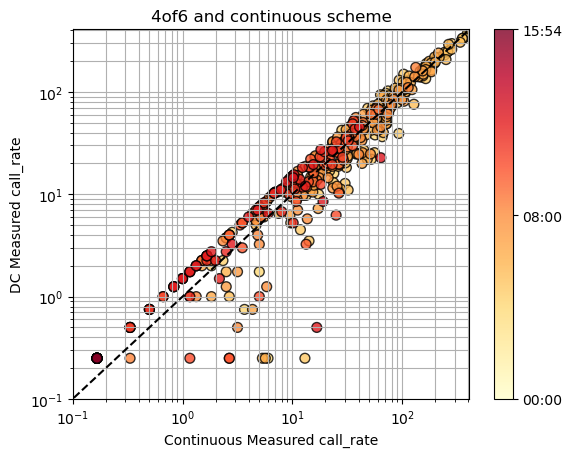

In [19]:
plot_indiv_dc_control_comp_over_cycle(plt_dcmetr, plt_cmetr, data_params)

In [20]:
def get_bout_duration_per_cycle(bout_metrics, cycle_length_in_mins):
    """
    Constructs a pandas Series that records the duration of time occupied by bouts observed per interval.
    The used interval is the cycle_length in minutes
    """

    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bout_metrics['total_bout_duration_in_secs'] = bout_metrics['bout_duration_in_secs']
    bout_metrics = bout_metrics.set_index('ref_time')

    bout_duration_per_interval = bout_metrics.resample(f"{cycle_length_in_mins}T")['total_bout_duration_in_secs'].sum()

    return bout_duration_per_interval

In [24]:
def generate_activity_btp_for_dc_schemes(data_params, file_paths):
    activity_arr = pd.DataFrame()
    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)

    dc_schemes = data_params['dc_tags'][1:]
    cont_scheme = data_params['dc_tags'][0]
    for dc_tag in dc_schemes:
        cycle_length_in_mins = int(dc_tag.split('of')[1])
        time_on_in_mins = int(dc_tag.split('of')[0])
        time_on_in_secs = (60*time_on_in_mins)

        dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), cycle_length_in_mins, 
                                                            time_on_in_secs, data_params)
        does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df)

        bout_metrics = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, time_on_in_mins)
        bout_duration = get_bout_duration_per_cycle(bout_metrics, cycle_length_in_mins)
        bout_time_percentage = 100*get_metric_per_time_on(bout_duration, time_on_in_secs)
        bout_time_percentage_dc_column = filter_and_prepare_metric(bout_time_percentage, dc_tag, data_params)
        bout_time_percentage_dc_column = bout_time_percentage_dc_column.set_index("datetime_UTC")
        are_there_expected_number_of_cycles(dc_applied_df, bout_time_percentage_dc_column, cycle_length_in_mins)

        activity_arr = pd.concat([activity_arr, bout_time_percentage_dc_column], axis=1)

    return activity_arr

def get_continuous_btp_partitioned_for_dc_scheme(metric_col_name, file_paths, data_params):
    dc_tag_split = re.findall(r"\d+", metric_col_name)
    dc_tag = re.findall(r"\d+of\d+", metric_col_name)[0]
    cycle_length = int(dc_tag_split[-1])
    cycle_length_in_secs = 60*cycle_length

    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
    dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), cycle_length, 
                                                        cycle_length_in_secs, data_params)
    does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df)
    bout_metrics = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, cycle_length)

    bout_duration = get_bout_duration_per_cycle(bout_metrics, cycle_length)
    bout_time_percentage = 100*get_metric_per_time_on(bout_duration, cycle_length_in_secs)
    bout_time_percentage_cont_column = filter_and_prepare_metric(bout_time_percentage, dc_tag, data_params)
    bout_time_percentage_cont_column = bout_time_percentage_cont_column.set_index("datetime_UTC")
    are_there_expected_number_of_cycles(location_df, bout_time_percentage_cont_column, cycle_length)

    return bout_time_percentage_cont_column

In [25]:
data_params['metric_tag'] = 'bout_time_percentage'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'

In [26]:
activity_arr = generate_activity_btp_for_dc_schemes(data_params, file_paths)

In [102]:
def generate_bout_metrics_for_location_and_freq(location_sum_df, data_params, time_on):
    """
    Given a location summary of calls dataframe, create an analogous location summary of bouts by:
    1) Calculating the BCI for each frequency group in the summary.
    2) Use the calculated BCI for each group to cluster bouts for that group.
    3) Put together all bout characteristics into the analogous dataframe.
    """

    location_sum_df.reset_index(drop=True, inplace=True)

    bout_params = bt.get_bout_params_from_location(location_sum_df, data_params)

    batdetect2_predictions = bt.classify_bouts_in_bd2_predictions_for_freqgroups(location_sum_df, bout_params)
    bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_predictions)

    bt.test_bout_end_times_in_period(bout_metrics, time_on)

    return bout_metrics

In [103]:
metric_for_scheme = pd.DataFrame(activity_arr.iloc[:,3].dropna())
metric_col_name = metric_for_scheme.columns[0]
# btp_cont_column = get_continuous_btp_partitioned_for_dc_scheme(metric_col_name, file_paths, data_params)
dc_tag_split = re.findall(r"\d+", metric_col_name)
dc_tag = re.findall(r"\d+of\d+", metric_col_name)[0]
time_on = int(dc_tag_split[0])
cycle_length = int(dc_tag_split[-1])
cycle_length_in_secs = 60*cycle_length

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), cycle_length, 
                                                    cycle_length_in_secs, data_params)
does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df)
# bout_metrics = generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, cycle_length)
# bout_metrics

,freq_group,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,number_of_dets,bout_duration,bout_duration_in_secs
0,LF,2022-07-13 04:55:13.597500,2022-07-13 04:55:23.927400,73.5975,83.9274,1513.5975,1523.9274,22890.0,33127.0,37,0 days 00:00:10.329900,10.3299
1,LF,2022-07-13 04:57:55.094500,2022-07-13 04:57:58.820900,235.0945,238.8209,1675.0945,1678.8209,26328.0,34097.0,4,0 days 00:00:03.726400,3.7264
2,LF,2022-07-13 05:05:25.821500,2022-07-13 05:05:28.472300,325.8215,328.4723,325.8215,328.4723,24609.0,29024.0,6,0 days 00:00:02.650800,2.6508
3,LF,2022-07-13 05:05:32.149500,2022-07-13 05:05:37.731600,332.1495,337.7316,332.1495,337.7316,23750.0,27951.0,16,0 days 00:00:05.582100,5.5821
4,LF,2022-07-13 05:05:47.819500,2022-07-13 05:05:51.224200,347.8195,351.2242,347.8195,351.2242,23750.0,30704.0,8,0 days 00:00:03.404700,3.4047
...,...,...,...,...,...,...,...,...,...,...,...,...
30611,LF,2022-10-17 05:52:01.605500,2022-10-17 05:52:04.888100,241.6055,244.8881,1321.6055,1324.8881,26328.0,42375.0,22,0 days 00:00:03.282600,3.2826
30612,LF,2022-10-17 05:52:23.962500,2022-10-17 05:52:27.146200,263.9625,267.1462,1343.9625,1347.1462,26328.0,37031.0,16,0 days 00:00:03.183700,3.1837
30613,LF,2022-10-17 07:39:03.094500,2022-10-17 07:39:08.725300,183.0945,188.7253,543.0945,548.7253,40078.0,77188.0,34,0 days 00:00:05.630800,5.6308
30614,LF,2022-10-17 07:56:34.765500,2022-10-17 07:56:42.410600,154.7655,162.4106,1594.7655,1602.4106,24609.0,31057.0,16,0 days 00:00:07.645100,7.6451


In [110]:
dc_applied_df.reset_index(drop=True, inplace=True)
bout_params = bt.get_bout_params_from_location(dc_applied_df, data_params)
bout_params

{'site_key': 'Carp', 'LF_bci': 2275.044560515865}

In [259]:
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
tagged_dets

,call_status,change_markers,bout_tag,duration_from_last_call_ms,start_time_wrt_ref,end_time_wrt_ref,freq_group,index_in_file,ref_time,call_start_time,...,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration,cycle_ref_time
0,outside bout,0.0,0,2.275045e+03,300.3355,300.3532,LF,0,2022-07-13 04:53:00.335500,2022-07-13 04:53:00.335500,...,Nyctalus leisleri,0.487,0.559,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:48:00
1,bout start,1.0,0,1.332443e+05,73.5975,73.6129,LF,1,2022-07-13 04:55:13.597500,2022-07-13 04:55:13.597500,...,Nyctalus leisleri,0.449,0.571,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
2,within bout,0.0,1,2.106000e+02,73.8235,73.8396,LF,2,2022-07-13 04:55:13.823500,2022-07-13 04:55:13.823500,...,Nyctalus leisleri,0.513,0.591,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
3,within bout,0.0,1,1.489000e+02,73.9885,74.0010,LF,3,2022-07-13 04:55:13.988500,2022-07-13 04:55:13.988500,...,Nyctalus leisleri,0.424,0.632,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
4,within bout,0.0,1,2.665000e+02,74.2675,74.2839,LF,4,2022-07-13 04:55:14.267500,2022-07-13 04:55:14.267500,...,Nyctalus leisleri,0.459,0.587,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902691,within bout,0.0,1,4.632000e+02,162.0255,162.0391,LF,49,2022-10-17 07:56:42.025500,2022-10-17 07:56:42.025500,...,Nyctalus leisleri,0.432,0.599,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 07:54:00
902692,bout end,-1.0,1,3.574000e+02,162.3965,162.4106,LF,50,2022-10-17 07:56:42.396500,2022-10-17 07:56:42.396500,...,Nyctalus leisleri,0.454,0.541,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 07:54:00
902693,bout start,1.0,0,5.048439e+06,170.8495,170.8573,LF,0,2022-10-17 09:20:50.849500,2022-10-17 09:20:50.849500,...,Pipistrellus pipistrellus,0.404,0.564,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 09:18:00
902694,bout end,-1.0,1,9.842000e+02,171.8415,171.8521,LF,1,2022-10-17 09:20:51.841500,2022-10-17 09:20:51.841500,...,Pipistrellus pipistrellus,0.305,0.556,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 09:18:00


In [208]:
test = tagged_dets.loc[(tagged_dets['call_start_time']>=dt.datetime(2022,7,16,7,0,12))&(tagged_dets['call_end_time']<=dt.datetime(2022,7,16,7,7,0))].copy()
first_call_of_cycle = ~test.duplicated(subset='cycle_ref_time', keep='first')
last_call_of_cycle = ~test.duplicated(subset='cycle_ref_time', keep='last')
calls_within_another_bout = test['call_status']=='within bout'

test.loc[first_call_of_cycle&calls_within_another_bout, 'call_status'] = 'bout start'
test.loc[last_call_of_cycle&calls_within_another_bout, 'call_status'] = 'bout end'

bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(test)
assert bout_metrics.shape[0] == 5

In [264]:
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)

first_call_of_cycle = ~tagged_dets.duplicated(subset='cycle_ref_time', keep='first')
last_call_of_cycle = ~tagged_dets.duplicated(subset='cycle_ref_time', keep='last')
calls_within_another_bout = tagged_dets['call_status']=='within bout'
calls_not_start_or_end_of_bout = (tagged_dets['call_status']=='bout start')|(tagged_dets['call_status']=='bout end')

In [ ]:
# tagged_dets.loc[first_call_of_cycle&calls_within_another_bout, 'call_status'] = 'bout start'
# tagged_dets.loc[last_call_of_cycle&calls_within_another_bout, 'call_status'] = 'bout end'

In [265]:
tagged_dets.loc[first_call_of_cycle&calls_within_another_bout]

,call_status,change_markers,bout_tag,duration_from_last_call_ms,start_time_wrt_ref,end_time_wrt_ref,freq_group,index_in_file,ref_time,call_start_time,...,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration,cycle_ref_time
458,within bout,0.0,1,647.799988,0.0735,0.0887,LF,14,2022-07-13 07:06:00.073500,2022-07-13 07:06:00.073500,...,Nyctalus leisleri,0.353,0.545,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 07:06:00
802,within bout,0.0,1,1088.500000,0.8405,0.8540,LF,362,2022-07-13 07:18:00.840500,2022-07-13 07:18:00.840500,...,Nyctalus leisleri,0.432,0.633,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 07:18:00
1120,within bout,0.0,1,348.799988,0.2275,0.2397,LF,208,2022-07-13 07:48:00.227500,2022-07-13 07:48:00.227500,...,Nyctalus leisleri,0.372,0.716,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 07:48:00
1225,within bout,0.0,1,673.900024,0.4395,0.4567,LF,313,2022-07-13 07:54:00.439500,2022-07-13 07:54:00.439500,...,Nyctalus leisleri,0.610,0.681,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 07:54:00
2228,within bout,0.0,1,966.000000,0.4605,0.4768,LF,295,2022-07-14 08:24:00.460500,2022-07-14 08:24:00.460500,...,Nyctalus leisleri,0.566,0.641,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-14 08:24:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896626,within bout,0.0,1,1774.900024,1.2715,1.2898,LF,286,2022-10-14 03:06:01.271500,2022-10-14 03:06:01.271500,...,Nyctalus leisleri,0.442,0.532,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-14 03:06:00
897806,within bout,0.0,1,1895.699951,0.4505,0.4701,LF,416,2022-10-16 02:18:00.450500,2022-10-16 02:18:00.450500,...,Nyctalus leisleri,0.232,0.514,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-16 02:18:00
898860,within bout,0.0,1,1363.800049,0.9195,0.9371,LF,373,2022-10-16 02:42:00.919500,2022-10-16 02:42:00.919500,...,Nyctalus leisleri,0.405,0.522,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-16 02:42:00
900184,within bout,0.0,1,222.399994,0.0655,0.0781,LF,288,2022-10-17 02:12:00.065500,2022-10-17 02:12:00.065500,...,Nyctalus leisleri,0.327,0.502,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 02:12:00


In [266]:
tagged_dets.loc[last_call_of_cycle&calls_within_another_bout]

,call_status,change_markers,bout_tag,duration_from_last_call_ms,start_time_wrt_ref,end_time_wrt_ref,freq_group,index_in_file,ref_time,call_start_time,...,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration,cycle_ref_time
457,within bout,0.0,1,357.200012,359.4115,359.4257,LF,13,2022-07-13 07:05:59.411500,2022-07-13 07:05:59.411500,...,Nyctalus leisleri,0.304,0.631,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 07:00:00
801,within bout,0.0,1,287.600006,359.7375,359.7520,LF,361,2022-07-13 07:17:59.737500,2022-07-13 07:17:59.737500,...,Nyctalus leisleri,0.696,0.762,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 07:12:00
1119,within bout,0.0,1,337.899994,359.8645,359.8787,LF,207,2022-07-13 07:47:59.864500,2022-07-13 07:47:59.864500,...,Nyctalus leisleri,0.263,0.546,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 07:42:00
1224,within bout,0.0,1,670.400024,359.7445,359.7656,LF,312,2022-07-13 07:53:59.744500,2022-07-13 07:53:59.744500,...,Nyctalus leisleri,0.535,0.574,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 07:48:00
2227,within bout,0.0,1,798.000000,359.4775,359.4945,LF,294,2022-07-14 08:23:59.477500,2022-07-14 08:23:59.477500,...,Nyctalus leisleri,0.534,0.609,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-14 08:18:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894694,within bout,0.0,1,698.599976,358.3775,358.3952,LF,420,2022-10-10 03:47:58.377500,2022-10-10 03:47:58.377500,...,Nyctalus leisleri,0.435,0.521,-1,/mnt/ubna_data_02/recover-20221010/UBNA_010/20...,Carp Pond,recover-20221010,10,NaN,2022-10-10 03:42:00
896625,within bout,0.0,1,392.700012,359.4785,359.4966,LF,285,2022-10-14 03:05:59.478500,2022-10-14 03:05:59.478500,...,Nyctalus leisleri,0.407,0.596,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-14 03:00:00
897805,within bout,0.0,1,629.400024,358.5395,358.5548,LF,415,2022-10-16 02:17:58.539500,2022-10-16 02:17:58.539500,...,Nyctalus leisleri,0.437,0.600,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-16 02:12:00
900183,within bout,0.0,1,150.100006,359.8305,359.8431,LF,287,2022-10-17 02:11:59.830500,2022-10-17 02:11:59.830500,...,Eptesicus serotinus,0.269,0.557,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 02:06:00


In [230]:
test2 = tagged_dets.loc[(first_call_of_cycle|last_call_of_cycle)]

In [234]:
assert test2.loc[test2['call_status']=='within bout'].empty

In [292]:
location_df = tagged_dets.copy()
location_df.reset_index(drop=True, inplace=True)

end_times_of_bouts = pd.to_datetime(location_df.loc[location_df['call_status']=='bout end', 'call_end_time'])
start_times_of_bouts = pd.to_datetime(location_df.loc[location_df['call_status']=='bout start', 'call_start_time'])
ref_end_times = location_df.loc[location_df['call_status']=='bout end', 'end_time_wrt_ref'].astype('float')
ref_start_times = location_df.loc[location_df['call_status']=='bout start', 'start_time_wrt_ref'].astype('float')
end_times = location_df.loc[location_df['call_status']=='bout end', 'end_time'].astype('float')
start_times = location_df.loc[location_df['call_status']=='bout start', 'start_time'].astype('float')

bout_starts = start_times_of_bouts.index
bout_ends = end_times_of_bouts.index

low_freqs = []
high_freqs = []
num_calls_per_bout = []
for i, bout_start in enumerate(bout_starts):
    bat_bout = location_df.iloc[bout_start:bout_ends[i]+1]
    pass_low_freq = np.min(bat_bout['low_freq'])
    pass_high_freq = np.max(bat_bout['high_freq'])
    num_calls = len(bat_bout)
    low_freqs += [pass_low_freq]
    high_freqs += [pass_high_freq]
    num_calls_per_bout += [num_calls]

bout_metrics = pd.DataFrame()
bout_metrics['start_time_of_bout'] = start_times_of_bouts.values
bout_metrics['end_time_of_bout'] = end_times_of_bouts.values
bout_metrics['start_time_wrt_ref'] = ref_start_times.values
bout_metrics['end_time_wrt_ref'] = ref_end_times.values
bout_metrics['start_time'] = start_times.values
bout_metrics['end_time'] = end_times.values
bout_metrics['low_freq'] = low_freqs
bout_metrics['high_freq'] = high_freqs
bout_metrics['number_of_dets'] = num_calls_per_bout
bout_metrics['bout_duration'] = end_times_of_bouts.values - start_times_of_bouts.values
bout_metrics['bout_duration_in_secs'] = bout_metrics['bout_duration'].apply(lambda x : x.total_seconds())
bout_metrics

In [273]:
bout_metrics[bout_metrics['bout_duration_in_secs']>=cycle_length_in_secs]

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,number_of_dets,bout_duration,bout_duration_in_secs
1061,2022-07-16 07:00:12.007500,2022-07-16 07:06:18.286600,12.0075,18.2866,12.0075,378.2866,21171.0,47719.0,1378,0 days 00:06:06.279100,366.2791
9364,2022-08-02 08:06:53.259500,2022-08-02 08:13:01.862800,53.2595,61.8628,413.2595,781.8628,17734.0,69551.0,1720,0 days 00:06:08.603300,368.6033
10249,2022-08-05 04:43:18.114500,2022-08-05 04:51:17.768700,78.1145,197.7687,798.1145,1277.7687,21171.0,53100.0,1882,0 days 00:07:59.654200,479.6542
13533,2022-08-11 04:33:46.008500,2022-08-11 04:42:35.559000,226.0085,35.5590,226.0085,755.5590,21171.0,60667.0,3642,0 days 00:08:49.550500,529.5505
21347,2022-09-01 03:33:51.952500,2022-09-01 03:59:54.881700,231.9525,354.8817,231.9525,1794.8817,20312.0,73602.0,12513,0 days 00:26:02.929200,1562.9292
21348,2022-09-01 04:00:00.129500,2022-09-01 04:15:06.910700,0.1295,186.9107,0.1295,906.9107,20312.0,46503.0,8223,0 days 00:15:06.781200,906.7812
21355,2022-09-01 04:23:29.281500,2022-09-01 04:29:54.937900,329.2815,354.9379,1409.2815,1794.9379,22031.0,62664.0,2420,0 days 00:06:25.656400,385.6564
21369,2022-09-01 04:43:47.067500,2022-09-01 04:57:04.188800,107.0675,184.1888,827.0675,1624.1888,21171.0,65131.0,4537,0 days 00:13:17.121300,797.1213
21388,2022-09-01 05:13:54.867500,2022-09-01 05:20:39.045700,114.8675,159.0457,834.8675,1239.0457,22031.0,49245.0,2555,0 days 00:06:44.178200,404.1782
22240,2022-09-09 04:00:00.048500,2022-09-09 04:07:30.515200,0.0485,90.5152,0.0485,450.5152,21171.0,50855.0,2422,0 days 00:07:30.466700,450.4667


In [294]:
bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
bout_metrics['cycle_ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])

resampled_cycle_length_df = bout_metrics.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
bout_metrics['cycle_ref_time'] = pd.DatetimeIndex(resampled_cycle_length_df['cycle_ref_time'].transform(lambda x: x.name))
bout_metrics

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,number_of_dets,bout_duration,bout_duration_in_secs,ref_time,cycle_ref_time
0,2022-07-13 04:55:13.597500,2022-07-13 04:55:23.927400,73.5975,83.9274,1513.5975,1523.9274,22890.0,33127.0,37,0 days 00:00:10.329900,10.3299,2022-07-13 04:55:13.597500,2022-07-13 04:54:00
1,2022-07-13 04:57:55.094500,2022-07-13 04:57:58.820900,235.0945,238.8209,1675.0945,1678.8209,26328.0,34097.0,4,0 days 00:00:03.726400,3.7264,2022-07-13 04:57:55.094500,2022-07-13 04:54:00
2,2022-07-13 05:05:25.821500,2022-07-13 05:05:28.472300,325.8215,328.4723,325.8215,328.4723,24609.0,29024.0,6,0 days 00:00:02.650800,2.6508,2022-07-13 05:05:25.821500,2022-07-13 05:00:00
3,2022-07-13 05:05:32.149500,2022-07-13 05:05:37.731600,332.1495,337.7316,332.1495,337.7316,23750.0,27951.0,16,0 days 00:00:05.582100,5.5821,2022-07-13 05:05:32.149500,2022-07-13 05:00:00
4,2022-07-13 05:05:47.819500,2022-07-13 05:05:51.224200,347.8195,351.2242,347.8195,351.2242,23750.0,30704.0,8,0 days 00:00:03.404700,3.4047,2022-07-13 05:05:47.819500,2022-07-13 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30611,2022-10-17 05:52:01.605500,2022-10-17 05:52:04.888100,241.6055,244.8881,1321.6055,1324.8881,26328.0,42375.0,22,0 days 00:00:03.282600,3.2826,2022-10-17 05:52:01.605500,2022-10-17 05:48:00
30612,2022-10-17 05:52:23.962500,2022-10-17 05:52:27.146200,263.9625,267.1462,1343.9625,1347.1462,26328.0,37031.0,16,0 days 00:00:03.183700,3.1837,2022-10-17 05:52:23.962500,2022-10-17 05:48:00
30613,2022-10-17 07:39:03.094500,2022-10-17 07:39:08.725300,183.0945,188.7253,543.0945,548.7253,40078.0,77188.0,34,0 days 00:00:05.630800,5.6308,2022-10-17 07:39:03.094500,2022-10-17 07:36:00
30614,2022-10-17 07:56:34.765500,2022-10-17 07:56:42.410600,154.7655,162.4106,1594.7655,1602.4106,24609.0,31057.0,16,0 days 00:00:07.645100,7.6451,2022-10-17 07:56:34.765500,2022-10-17 07:54:00


In [295]:
bout_metrics['total_bout_duration_in_secs'] = bout_metrics['bout_duration_in_secs']
bout_metrics = bout_metrics.set_index('cycle_ref_time')

bout_duration_per_interval = bout_metrics.resample(f"{cycle_length}T")['total_bout_duration_in_secs'].sum()
bout_duration_per_interval

cycle_ref_time
2022-07-13 04:54:00    14.0563
2022-07-13 05:00:00    11.6376
2022-07-13 05:06:00     0.6696
2022-07-13 05:12:00     0.0000
2022-07-13 05:18:00     0.0000
                        ...   
2022-10-17 08:54:00     0.0000
2022-10-17 09:00:00     0.0000
2022-10-17 09:06:00     0.0000
2022-10-17 09:12:00     0.0000
2022-10-17 09:18:00     1.0026
Freq: 6T, Name: total_bout_duration_in_secs, Length: 23085, dtype: float64

In [296]:
bout_duration_per_interval[(bout_duration_per_interval>=cycle_length_in_secs)]

cycle_ref_time
2022-07-15 06:12:00    382.4548
2022-07-16 07:00:00    366.2791
2022-07-16 07:06:00    367.7528
2022-07-18 05:48:00    432.1729
2022-07-20 09:42:00    449.3730
                         ...   
2022-09-16 03:00:00    451.4172
2022-09-17 03:30:00    377.6995
2022-09-21 03:48:00    422.4599
2022-09-27 03:00:00    403.9164
2022-09-27 03:12:00    434.5866
Name: total_bout_duration_in_secs, Length: 67, dtype: float64

In [297]:
bout_time_percentage = 100*get_metric_per_time_on(bout_duration_per_interval, cycle_length_in_secs)
bout_time_percentage_cont_column = filter_and_prepare_metric(bout_time_percentage, dc_tag, data_params)
bout_time_percentage_cont_column = bout_time_percentage_cont_column.set_index("datetime_UTC")
are_there_expected_number_of_cycles(location_df, bout_time_percentage_cont_column, cycle_length)

bout_time_percentage_cont_column

,bout_time_percentage (4of6)
datetime_UTC,
2022-07-13 04:54:00,3.904528
2022-07-13 05:00:00,3.232667
2022-07-13 05:06:00,0.186000
2022-07-13 05:12:00,0.000000
2022-07-13 05:18:00,0.000000
...,...
2022-10-17 08:54:00,0.000000
2022-10-17 09:00:00,0.000000
2022-10-17 09:06:00,0.000000


In [298]:
bout_time_percentage_cont_column[bout_time_percentage_cont_column>100].dropna()

,bout_time_percentage (4of6)
datetime_UTC,
2022-07-15 06:12:00,106.237444
2022-07-16 07:00:00,101.744194
2022-07-16 07:06:00,102.153556
2022-07-18 05:48:00,120.048028
2022-07-20 09:42:00,124.825833
...,...
2022-09-16 03:00:00,125.393667
2022-09-17 03:30:00,104.916528
2022-09-21 03:48:00,117.349972


In [299]:

metric_for_scheme_for_comparison = get_associated_metric_for_cont_column(metric_for_scheme, call_rate_cont_column)

data_params['start'] = dt.datetime(2022, 8, 10, 0, 0, 0)
data_params['end'] = dt.datetime(2022, 8, 16, 16, 0, 0)

plt_dcmetr, plt_cmetr = select_dates_from_metrics(metric_for_scheme_for_comparison, call_rate_cont_column, data_params)

In [63]:
assert (btp_cont_column>=90).any().item() and (btp_cont_column>=0).all().item()

In [64]:
assert (metric_for_scheme>=90).any().item() and (metric_for_scheme>=0).all().item()

In [66]:
def plot_indiv_dc_control_comp_over_cycle(single_col_dc_metr1, single_col_c_metr, data_params):
    dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
    total = int(dc_tag_split[-1])
    single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
    dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                        columns=single_col_dc_metr1.index.date, 
                        values=single_col_dc_metr1.columns[0])
    dctag1 = re.search(r"\d+of\d+", single_col_dc_metr1.columns[0])[0]
    metrictag1 = (single_col_dc_metr1.columns[0]).split()[0]
    single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
    paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    plt.title(f'{dctag1} and continuous scheme')
    plt.plot([0, np.amax(c_metr)], [0, np.amax(c_metr)], linestyle='dashed', color='k')
    colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
    labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
    sc = plt.scatter(c_metr, dc_metr1, c=colors, cmap='YlOrRd', edgecolors='k', s=50, alpha=0.8)
    cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
    cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
    plt.xlabel(f'Continuous Measured {metrictag1}')
    plt.xscale('log')
    plt.yscale('log')
    if (data_params['metric_tag'] == 'bout_time_percentage'):
        plt.xlim(1e-2, 1e3)
        plt.ylim(1e-2, 1e3)
    else:
        plt.xlim(1e-1, np.amax(c_metr))
        plt.ylim(1e-1, np.amax(c_metr))
    plt.ylabel(f'DC Measured {metrictag1}')
    plt.grid(which='both')

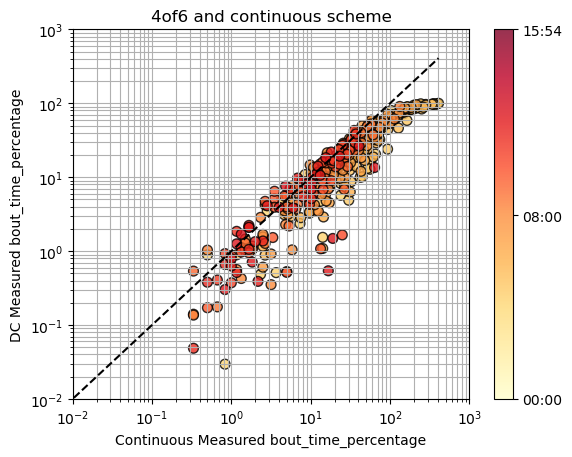

In [300]:
plot_indiv_dc_control_comp_over_cycle(plt_dcmetr, plt_cmetr, data_params)